In [17]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
import time
import math
import matplotlib.pyplot as plt
import numpy as np

# Scrapping

In [140]:
driver = webdriver.Chrome(service= Service(ChromeDriverManager().install()))
url = "https://www.etsy.com/search?q=bedding&ref=pagination&page="

df = None

# Scrap about 100 pages
for i in range(1,101):
    driver.get(url + str(i))
    
    
    time.sleep(5) # Wait 5 seconds to avoid robot checking.

    grid = driver.find_element(By.CSS_SELECTOR, "ol")
    items = grid.find_elements(By.CSS_SELECTOR, "li")

    datas = []
    for li in items:

        # Define data structure
        data = {
            "Title": None,
            "Seller": None,
            "Rating": None,
            "Reviews": None,
            "Sale Price": None,
            "is_advertisement": False,
            "Original Price": None,
            "Discount": None
        }

        title = li.find_element(By.CSS_SELECTOR, "h3").text
        data["Title"] = title
        
        rating_box = li.find_element(By.CLASS_NAME, "streamline-spacing-shop-rating")
        rating_info = rating_box.find_elements(By.CSS_SELECTOR, "span")

        # If first rating info's text length is over zero, get rating and review info.
        if len(rating_info[0].text) > 0:
            rating = rating_info[0].text.split("\n")[0]
            data["Rating"] = float(rating)

            reviews = rating_info[0].text.split("\n")[1][1:-1]
            if reviews[-1] == "k": # If review text's last character is "k", multiply 1000.
                reviews = int(float(reviews[:-1])*1000)
            else:
                reviews = int(reviews)
            data["Reviews"] = reviews

        if rating_info[-4].text.startswith("Ad"):
            data["is_advertisement"] = True
        else:
            data["Seller"] = rating_info[-2].text

        ps = li.find_elements(By.CSS_SELECTOR, "p")
        for p in ps:
            if p.text.startswith("Sale Price"):
                data["Sale Price"] = p.text.split("\n")[-1]
            elif p.text.startswith("$"):
                data["Original Price"] = p.text.split("\n")[0]
                if data["Sale Price"] is not None:
                    data["Discount"] = int(p.text.split("\n")[-1][1:-6])/100
        
        datas.append(data)
    if df is None:
        df = pd.DataFrame(datas)
    else:
        df = pd.concat([df, pd.DataFrame(datas)], ignore_index=True)

# Data Preprocessing
# Name
names = []
for v in list(df.iloc[:,1]):
    if isinstance(v, float):
        names.append("AD")
    else:
        names.append(v)
df.iloc[:,1] = names

# Sale Price, Original Price, Discount
sales = []
originals = []
discounts = []

for sp, op, dc in zip(list(df.iloc[:,4]), list(df.iloc[:,6]), list(df.iloc[:,7])):
    op = float("".join(op[1:].split(",")))
    originals.append(op)
    if isinstance(sp, float):
        sales.append(op)
        discounts.append(0.0)
    else:
        sp = float("".join(sp[1:].split(",")))
        sales.append(sp)
        discounts.append(float(dc))

df.iloc[:,4] = sales
df.iloc[:,6] = originals
df.iloc[:,7] = discounts

# Saving
df.to_csv("result.csv")

',Title,Seller,Rating,Reviews,Sale Price,is_advertisement,Original Price,Discount\n0,"Linen Bedding set in Green (3 PCS), Duvet Cover and Two Pillowcases Queen King Custom sizes,",,4.8,566.0,,True,$187.00,\n1,Soft Sheet Set - Floral Patterned 4 Piece Bedding Set | Available in Multiple Sizes,,4.7,1600.0,$18.74,True,$24.99,0.25\n2,"Stonewashed Cotton Linen Soft Bed Linen, Natural Farmhouse King Duvet Cover Set, Minimalist Queen Bedding Set, Breathable Double Quilt Cover",,4.8,250.0,$76.99,True,$109.99,0.3\n3,"5 Layers King Size Gauze Comforter , OEKO-TEX Certified, Muslin Quilt, Organic Throw Blanket",,4.9,716.0,$139.30,True,$199.00,0.3\n4,French Retro Pink Floral 100% Cotton Duvet Cover Set- Princess Ruffle Bedding- Cottagecore Decor- Twin Full Queen King Duvet Cover- Gift,AkeyCrafts,4.4,1300.0,$63.19,False,$126.38,0.5\n5,Reversible Lightweight Comforter All Season Down Alternative Summer Duvet Insert Quilted Bedding Comforters with Corner Tabs Full/Queen Size,SnowglassShop,4.6,36.0,$4

# Visualize

In [2]:
data = pd.read_csv("./result(Jaehun_Jung).csv", )
data = data.iloc[:,1:]

In [3]:
data

,Title,Seller,Rating,Reviews,Sale Price,is_advertisement,Original Price,Discount
0,"Linen Bedding set in Green (3 PCS), Duvet Cove...",AD,4.8,566.0,187.00,True,187.00,0.00
1,Soft Sheet Set - Floral Patterned 4 Piece Bedd...,AD,4.7,1600.0,18.74,True,24.99,0.25
2,"Stonewashed Cotton Linen Soft Bed Linen, Natur...",AD,4.8,250.0,76.99,True,109.99,0.30
3,"5 Layers King Size Gauze Comforter , OEKO-TEX ...",AD,4.9,716.0,139.30,True,199.00,0.30
4,French Retro Pink Floral 100% Cotton Duvet Cov...,AkeyCrafts,4.4,1300.0,63.19,False,126.38,0.50
...,...,...,...,...,...,...,...,...
6395,"Girl Crib Bedding, Vintage Floral, Baby Girl N...",ModifiedTot,4.8,4900.0,58.50,False,65.00,0.10
6396,Rustic Duck Hunting Fishing Camo Outdoors Deer...,mellissasboutique,4.9,980.0,49.00,False,49.00,0.00
6397,MUSTARD cotton Quilt with coordinated pillow c...,VLiving,4.8,3500.0,24.64,False,28.00,0.12
6398,Gentle Pink Floral Coral Velvet Duvet Cover Se...,AkeyCrafts,4.4,1300.0,83.34,False,166.68,0.50


## Categorical variables distrubution

In [38]:
# Gaussian Distribution
def get_gaussian_func(data):
    values = []
    for d in data:
        if math.isnan(float(d)):
            values.append(0.)
        else:
            values.append(float(d))

    mean = sum(values) / max(1, len(values))
    
    variance = [(value - mean)**2 for value in values]
    variance = sum(variance) / max(1, len(variance))

    def func(x):
        return 1/(np.sqrt(variance)*np.sqrt(2*np.pi))*np.exp(-((x-mean)**2)/(2*variance))
    
    return func, mean, math.sqrt(variance)

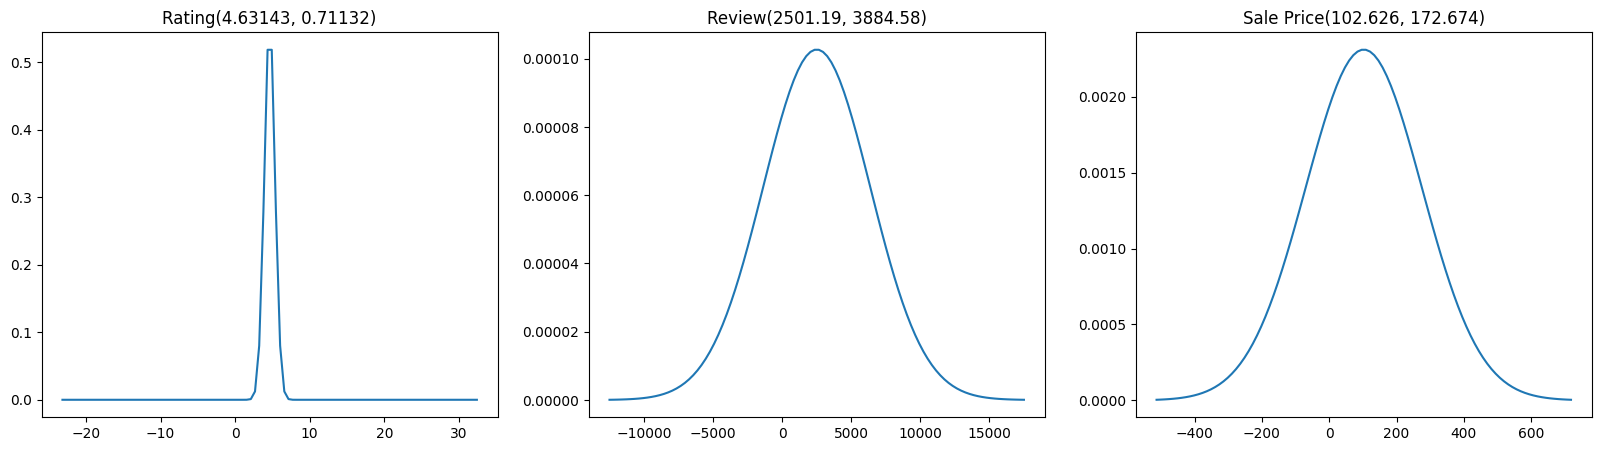

In [52]:
plt.figure(figsize=(20,5))
for i in range(2,5,1):
    gaussian_func, mean, std_dev = get_gaussian_func(data.iloc[:,i])
    if i == 2:
        name = "Rating"
    elif i==3:
        name = "Review"
    else:
        name = "Sale Price"

    name += f"({(str(mean)[:7])}, {str(std_dev)[:7]})"

    x = np.linspace(-5*mean, mean*7, 100)
    y = gaussian_func(x)

    plt.subplot(1,3,i-1)
    plt.plot(x, y)
    plt.title(name)

In [69]:
sellers = list(data.iloc[:,1])
ratings = list(data.iloc[:,2])
reviews = list(data.iloc[:,3])
sale_prices = list(data.iloc[:,4])

In [67]:
AD_count = 0
not_AD_count = 0

for seller in sellers:
    if seller == "AD":
        AD_count += 1
    else:
        not_AD_count += 1

print("All :", len(sellers))
print("AD count :", AD_count)
print("not AD count :", not_AD_count)

All : 6400
AD count : 1600
not AD count : 4800


[AD rating]
Mean: 4.828338762214984
Standard deviation: 0.1373012661382206
Minimum value: 4.2
Median value: 4.9
Maximum value: 5.0

[Others]
Mean: 4.689810126582278
Standard deviation: 0.30895148292313784
Minimum value: 1.0
Median value: 4.8
Maximum value: 5.0


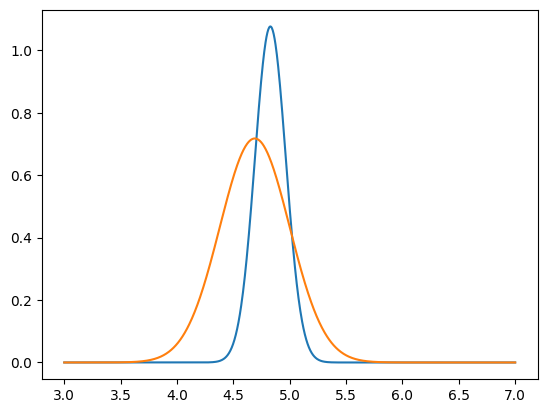

In [98]:
AD_ratings = []
not_AD_ratings = []

for i, (seller, rating) in enumerate(zip(sellers, ratings)):
    if math.isnan(float(rating)):
        continue

    if seller == "AD":
        AD_ratings.append(float(rating))
    else:
        not_AD_ratings.append(float(rating))

print("[AD rating]")
print("Mean:", np.mean(AD_ratings))
print("Standard deviation:", np.var(AD_ratings)**0.5)
print("Minimum value:", np.min(AD_ratings))
print("Median value:", np.median(AD_ratings))
print("Maximum value:", np.max(AD_ratings))

print()

print("[Others]")
print("Mean:", np.mean(not_AD_ratings))
print("Standard deviation:", np.var(not_AD_ratings)**0.5)
print("Minimum value:", np.min(not_AD_ratings))
print("Median value:", np.median(not_AD_ratings))
print("Maximum value:", np.max(not_AD_ratings))

x = np.linspace(3,7,1000)
y1 = 1/(np.sqrt(np.var(AD_ratings)**0.5)*np.sqrt(2*np.pi))*np.exp(-((x-np.mean(AD_ratings))**2)/(2*np.var(AD_ratings)))
y2 = 1/(np.sqrt(np.var(not_AD_ratings)**0.5)*np.sqrt(2*np.pi))*np.exp(-((x-np.mean(not_AD_ratings))**2)/(2*np.var(not_AD_ratings)))

plt.plot(x, y1, x, y2)


[AD review]
Mean: 4042.3752442996743
Standard deviation: 4620.1155467211975
Minimum value: 1.0
Median value: 2900.0
Maximum value: 50700.0

[Others]
Mean: 2068.057805907173
Standard deviation: 3512.891009519046
Minimum value: 1.0
Median value: 916.5
Maximum value: 44900.0


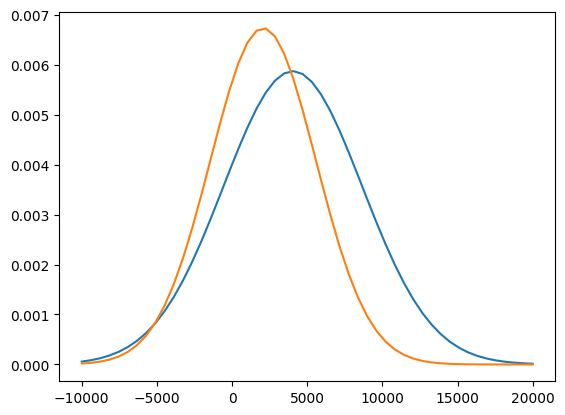

In [93]:
AD_reviews = []
not_AD_reviews = []

for i, (seller, review) in enumerate(zip(sellers, reviews)):
    if math.isnan(float(review)):
        continue

    if seller == "AD":
        AD_reviews.append(float(review))
    else:
        not_AD_reviews.append(float(review))

print("[AD review]")
print("Mean:", np.mean(AD_reviews))
print("Standard deviation:", np.var(AD_reviews)**0.5)
print("Minimum value:", np.min(AD_reviews))
print("Median value:", np.median(AD_reviews))
print("Maximum value:", np.max(AD_reviews))

print()

print("[Others]")
print("Mean:", np.mean(not_AD_reviews))
print("Standard deviation:", np.var(not_AD_reviews)**0.5)
print("Minimum value:", np.min(not_AD_reviews))
print("Median value:", np.median(not_AD_reviews))
print("Maximum value:", np.max(not_AD_reviews))

x = np.linspace(-10000,20000)
y1 = 1/(np.sqrt(np.var(AD_reviews)**0.5)*np.sqrt(2*np.pi))*np.exp(-((x-np.mean(AD_reviews))**2)/(2*np.var(AD_reviews)))
y2 = 1/(np.sqrt(np.var(not_AD_reviews)**0.5)*np.sqrt(2*np.pi))*np.exp(-((x-np.mean(not_AD_reviews))**2)/(2*np.var(not_AD_reviews)))

plt.plot(x, y1, x, y2)


[AD sale prices]
Mean: 128.46719375
Standard deviation: 130.1011758519594
Minimum value: 0.77
Median value: 99.0
Maximum value: 3150.0

[Others]
Mean: 94.01358958333333
Standard deviation: 183.89213629397187
Minimum value: 0.2
Median value: 64.99
Maximum value: 11329.82


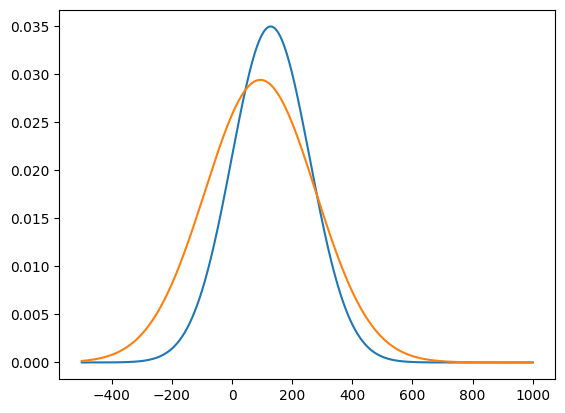

In [99]:
AD_sale_prices = []
not_AD_sale_prices = []

for i, (seller, sale_price) in enumerate(zip(sellers, sale_prices)):
    if math.isnan(float(sale_price)):
        continue

    if seller == "AD":
        AD_sale_prices.append(float(sale_price))
    else:
        not_AD_sale_prices.append(float(sale_price))

print("[AD sale prices]")
print("Mean:", np.mean(AD_sale_prices))
print("Standard deviation:", np.var(AD_sale_prices)**0.5)
print("Minimum value:", np.min(AD_sale_prices))
print("Median value:", np.median(AD_sale_prices))
print("Maximum value:", np.max(AD_sale_prices))

print()

print("[Others]")
print("Mean:", np.mean(not_AD_sale_prices))
print("Standard deviation:", np.var(not_AD_sale_prices)**0.5)
print("Minimum value:", np.min(not_AD_sale_prices))
print("Median value:", np.median(not_AD_sale_prices))
print("Maximum value:", np.max(not_AD_sale_prices))

x = np.linspace(-500,1000, 10000)
y1 = 1/(np.sqrt(np.var(AD_sale_prices)**0.5)*np.sqrt(2*np.pi))*np.exp(-((x-np.mean(AD_sale_prices))**2)/(2*np.var(AD_sale_prices)))
y2 = 1/(np.sqrt(np.var(not_AD_sale_prices)**0.5)*np.sqrt(2*np.pi))*np.exp(-((x-np.mean(not_AD_sale_prices))**2)/(2*np.var(not_AD_sale_prices)))

plt.plot(x, y1, x, y2)

